In [1]:
# DEPENDENCIES declaration
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import create_engine, MetaData, Table, Column, ForeignKey
from sqlalchemy.ext.automap import automap_base

# Reflect Tables into SQLAlchemy ORM
- SQLAlchemy ORM queries, Pandas, and Matplotlib.


In [2]:
# Use SQLAlchemy create_engine to connect to your sqlite database.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# Collect the names of tables within the database
engine.table_names()
print(engine.table_names())

['measurement', 'station']


In [4]:
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
print(f'Columns in measurement table:')
for c in columns:
    print(c['name'], c["type"])

    
columns = inspector.get_columns('station')
print(f'Columns in station table:')
for c in columns:
    print(c['name'], c["type"])

Columns in measurement table:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
Columns in station table:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

session = Session(engine)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
print(Base.classes.keys())

['measurement', 'station']


In [6]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(func.max(Measurement.date)).scalar()
last_date

date_time_obj = dt.datetime.strptime(last_date, '%Y-%m-%d')
year = dt.timedelta(days=365)

last_date_last_year = date_time_obj - year
# print('Last date detected on data:', last_date)
print('Last date detected on data:', date_time_obj)
print('Last date from previous year on data:', last_date_last_year)


Last date detected on data: 2017-08-23 00:00:00
Last date from previous year on data: 2016-08-23 00:00:00


In [7]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_date_last_year).order_by(Measurement.date).all()
# precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>="2016-08-23").all()
# precipitation

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(precipitation)
df.columns = precipitation[0].keys()
df.set_index("date").fillna(0).head(10)
# df.sort_values(by=['date'], ascending=False)
# df.set_index("date").dropna().head(10)
# df.set_index("date")

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,0.00
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.08
2016-08-25,0.08


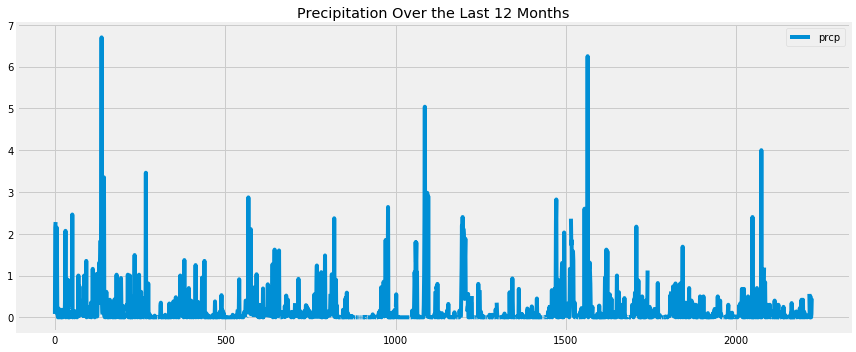

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(12, 5), x_compat=True)
# df.plot('date','prcp')
# df.plot('date', 'prcp', figsize=(12, 8), x_compat=True, color='green')
#set the title
plt.title('Precipitation Over the Last 12 Months')
plt.tight_layout()
# plt.set_xlabel("date")          
#rotate the x labels 45 degrees
# plt.xticks(rotation=45)
#make it a tight layout
plt.show()


In [9]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


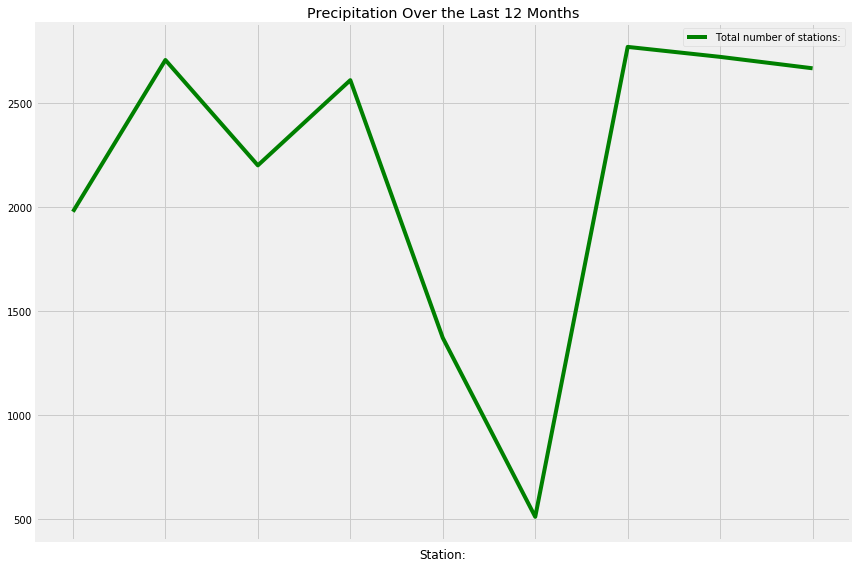

[('USC00511918', 1979), ('USC00513117', 2709), ('USC00514830', 2202), ('USC00516128', 2612), ('USC00517948', 1372), ('USC00518838', 511), ('USC00519281', 2772), ('USC00519397', 2724), ('USC00519523', 2669)]


In [10]:
station_number = session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).all()

precipitation_df = pd.DataFrame(station_number, columns=['Station:', 'Total number of stations:'])
precipitation_df.set_index('Station:', inplace=True)
precipitation_df.head()

# print('Number of stations:', precipitation_df.head())
precipitation_df

precipitation_df.plot(figsize=(12, 8), x_compat=True, color='green')



#set the title
plt.title('Precipitation Over the Last 12 Months')
# plt.set_xlabel("date")
          
#rotate the x labels 45 degrees
# plt.xticks(rotation='45')

#make it a tight layout
plt.tight_layout()

plt.show()
precipitation_df.head()
print(station_number)


# Exploratory Climate Analysis

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Get the dates for the last 12 months 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc())

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data


![precipitation](Images/precipitation.png)

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

![describe](Images/describe.png)

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
